# Machine Learning Essentials SS25 - Exercise Sheet 4

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

## Exercise 2

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

### Task 1

a)
$$\frac{d}{dx}\tanh(x) = \frac{d}{dx} \frac{\sinh(x)}{\cosh(x)} = 1 - \tanh(x)^2 = \frac{\cosh(x)^2-\sinh(x)^2}{\cosh(x)^2} = \frac{1}{\cosh(x)^2}$$
b)
$$\mathcal{L}(y,\hat{y}) = -[y \ln(\hat{y})+ (1-y) \ln(1-\hat{y})] \quad \Rightarrow \quad \mathcal{\delta}^{(2)} =\frac{\partial \mathcal{L}}{\partial\tilde{z}^{(2)}}=\frac{\partial \mathcal{L}}{\partial z^{(2)}}\frac{\partial z^{(2)}}{\partial\tilde{z}^{(2)}}$$
with 
$$ \frac{\partial \mathcal{L}}{\partial z^{(2)}} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})} \quad \mathrm{and} \quad \frac{\partial z^{(2)}}{\partial\tilde{z}^{(2)}} = \partial_{\tilde{z}^{(2)}} \sigma(\tilde{z}^{(2)}) = \sigma(\tilde{z}^{(2)})\sigma(-\tilde{z}^{(2)}) = \hat{y}(1-\hat{y})$$
and thus
$$\delta^{(2)}=\hat{y}-y$$

### Task 2

In [127]:
# TODO: Define the needed helper functions
def tanh_prime(x_activated):
    return 1 / (np.cosh(x_activated) ** 2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(y_hat, y):
    """
    Computes the BCE loss over samples.
    """
    # Hint: Add a small epsilon to y_hat to prevent numerical issues w/ log(0) issues (that's common practice in these cases)
    epsilon = 1e-20
    y_hat += epsilon
    return np.mean(-(y*np.log(y_hat.flatten())+(1-y)*np.log(1-y_hat.flatten())))

In [128]:
# MLP Class
class MLP:
    def __init__(self, layer_dims, initialization_scale=1):
        """
        Initializes the multi-layer perceptron.
        Args:
            layer_dims (list of int): List containing the number of neurons in each layer.
                                      [d0, d1, d2] = [2, 10, 1] for the exercise.
                                      d0: input dimension
                                      d1: hidden layer dimension
                                      d2: output dimension
            initialization_scale (float): Scaling factor for weight initialization (i.e. standard deviation of the normal distribution)
        """
        self.parameters = {} #initialise dictionary
        self.num_layers = len(layer_dims) 

        # Weights are initialized by drawing from a standard normal distribution, biases are initialized as zero.
        # For more complex networks, one usually uses techniques like Xavier or He initialization. Play around with the initialization_scale parameter to see how it affects the training!
        # Layer 0 -> Layer 1
        self.parameters['W0'] = np.random.randn(layer_dims[1], layer_dims[0]) * initialization_scale 
        self.parameters['b0'] = np.zeros((layer_dims[1], 1))
        # Layer 1 -> Layer 2
        self.parameters['W1'] = np.random.randn(layer_dims[2], layer_dims[1]) * initialization_scale
        self.parameters['b1'] = np.zeros((layer_dims[2], 1))
        
        self.cache = {} # For storing intermediate values (needed for backprop)

    def forward(self, X_batch):
        """
        Forward pass through the network. Store intermediate values in self.cache for backward pass.
        """
        # TODO: Implement the forward pass & store the needed values in self.cache
        z_1_preact = X_batch @ self.parameters['W0'].T + self.parameters['b0'].T
        z_1 = np.tanh(z_1_preact)
        y_hat = sigmoid(z_1 @ self.parameters['W1'].T + self.parameters['b1'].T)
        self.cache['z0'] = X_batch
        self.cache['z1_preact'] = z_1_preact
        self.cache['z1'] = z_1
        self.cache['y_hat'] = y_hat
        return y_hat

    def backward(self, Y_batch):
        """
        Performs the backward pass (= backpropagation) to compute gradients of the loss with respect to the parameters.
        Gradients are stored in the grads dictionary (see update_params method).
        """
        # TODO: Implement the backward pass
        grads = {}
        del_2 = self.cache['y_hat'].T - Y_batch
        grads['dW1'] = np.mean(self.cache['z1'].T * del_2,axis=1)
        grads['db1'] = np.mean(del_2,axis=1) 
        del_1 = (self.parameters['W1'].T @ del_2)  * tanh_prime(self.cache['z1_preact']).T 
        grads['dW0'] = np.mean(del_1[np.newaxis,:] * self.cache['z0'].T[:,np.newaxis],axis=2) 
        grads['db0'] = np.mean(del_1,axis=1)

        return grads

    def update_params(self, grads, learning_rate):
        """
        Updates the parameters using gradient descent.
        Args:
            grads (dict): Dictionary of gradients.
            learning_rate (float): The learning rate.
        """
        self.parameters['W0'] -= learning_rate * grads['dW0'].T
        self.parameters['b0'] -= learning_rate * grads['db0'][:,np.newaxis]
        self.parameters['W1'] -= learning_rate * grads['dW1'].T
        self.parameters['b1'] -= learning_rate * grads['db1'].T

### Task 3
TODO: Explain why using vectorized operations is generally preferred in ML.

Using the built-in vectorized operations of numpy looping is performed in C instead of Python.

### Task 4

In [129]:
#Data loading and preprocessing (predefined)
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# NOTE: Different libraries/languages use different conventions for the shape of the data matrix X, which comes from the way they store data in memory:
#   - In ML textbooks/mathematical notation, X is often (n_features, n_samples), because each sample is a (n_features, 1) column vector and we stack them "horizontally".
#   - This is consistent with some languages (e.g. Julia, Matlab), which store data in column-major order.
#   - However, most ML code (e.g. NumPy, sklearn, Pytorch) is optimized for row-major order, so you will in code most often see data matrices of shape (n_samples, n_features).
#     (The reason for that is that most of these libraries run C/C++/CUDA code under the hood, which is optimized for row-major order)
# --> Juggling the shapes of arrays to be correctly aligned with the used model implementation / convention is a day-to-day task in practical ML and the cause of many bugs, so always double-check the expected format.

# TODO: The MLP class you're using expects its inputs in a specific shape, make sure your X and y match that convention.
print(f"Shape of X_train: {X_train.shape}") 
print(f"Shape of y_train: {y_train.shape}") 
print(f"Shape of X_test: {X_test.shape}") 
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (350, 2)
Shape of y_train: (350,)
Shape of X_test: (150, 2)
Shape of y_test: (150,)


In [171]:
# Training
layer_dimensions = [X_train.shape[1], 10, 1] # d0, d1, d2 as given in the exercise
mlp = MLP(layer_dimensions) # Initialize the MLP

# Hyperparameters
learning_rate = 3# TODO: Experiment with this
num_epochs = 10000# TODO: Experiment with this
print_loss = int(num_epochs / 20) # To monitor the training process, print the loss every few epochs
train_losses = []
eval_epochs = []

for epoch in range(1,num_epochs+1):
    # Forward pass
    y_hat_train = mlp.forward(X_train)
    # Compute loss
    train_loss = binary_cross_entropy(y_hat_train, y_train)
    # Backward pass = backprop
    grads = mlp.backward(y_train)
   # Update parameters by gradient descent
    mlp.update_params(grads, learning_rate)
    
    if epoch % print_loss == 0 or epoch == num_epochs:
       train_losses.append(train_loss)
       eval_epochs.append(epoch) 
       #print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss:.4f}")

#### a)

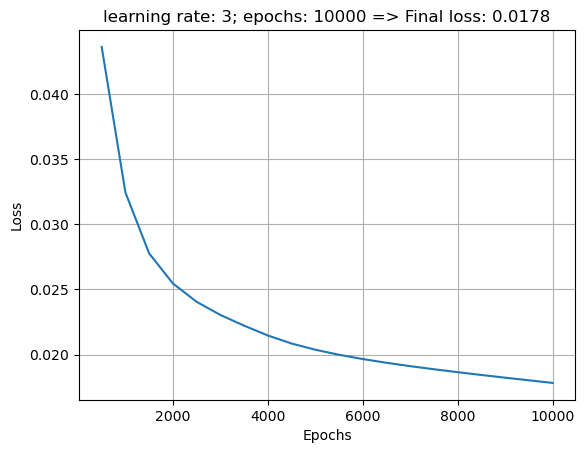

In [172]:
plt.plot(eval_epochs,train_losses)
plt.title(f"learning rate: {learning_rate}; epochs: {num_epochs} => Final loss: {train_losses[-1]:.4f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

In [ ]:
# Evaluation 
# TODO: Compute the accuracy on the test set and plot the decision boundary over the test set, comment on the performance
y_pred = [1 if mlp.forward(X_test)[i] > 0.5 else 0 for i in range(len(X_test))]
accuracy_score(y_test,y_pred)

(150, 2)


0.9733333333333334

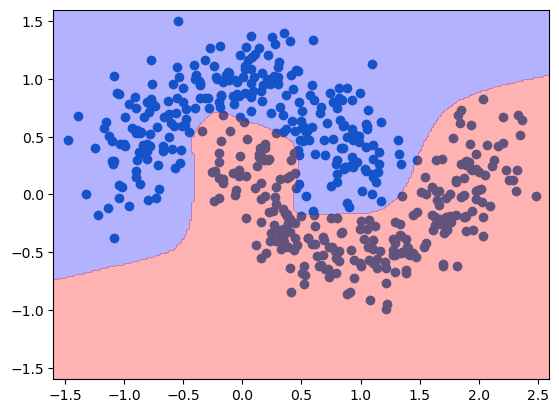

In [193]:
plt.scatter(X[:,0],X[:,1])
xx,yy = np.meshgrid(np.linspace(-1.6,2.6,200),np.linspace(-1.6,1.6,200))
grid = np.vstack([xx.ravel(), yy.ravel()])

grid_pred = np.array([1 if mlp.forward(grid[:,i]) > 0.5 else 0 for i in range(len(grid[0,:]))])
grid_pred = grid_pred.reshape(xx.shape)
plt.contourf(xx, yy, grid_pred, levels=[0, 0.5, 1], alpha=0.3, colors=('blue', 'red'))


The decision boundary within distribution is reasonable. It isn't perfect, but does follow the general separating contour of the two groups. Out of distribution it continues smoothly, and since there's no data, I'd say any sensible continuation of the boundary is reasonable, as is present here.

# Task 3: Neural Playground

### 1. 

The final network architecture which was able to learn the structure of the spiral dataset was with 6 hidden layers and 6 neurons. For the learning rate we chose 0.003, which we reduced to 0.001 at some point (after around 4000 epochs) for refinement. As activation we used ReLU. All other activation functions were not able to learn the dataset and got stuck at some point in the training process. With 5 neurons the training did not always succeed and with 4 neurons failed. After 5000 epochs the error on the test set was below 0.1. 

### 2. 

With no regularization the overall test loss was the highest (0.65), and also the overall weights of the neurons had high values compared to the L1/L2 regularization. For the L1 regularization the weights were all close to zero and the test error reduced a bit compared to no regularization (0.55). For the L2 regularization the weights were higher than in L1 but not as high as in no regularization. The test error reduced again a bit compared to the other methods (0.41), but none of the models was able to learn the underlying true distribution. But for this we simply do not have enough datapoints. For the regularization weight we used 0.003. With higher weight for L1 the weights were almost all very close to zero and we kept this weight for L2 regularization

